In [22]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from datasim.ecg.ecg_simulate import *
from datasim.scg.scg_simulate import *

In [30]:
scg_l = []
for i in range(10):
    scg = scg_simulate(duration=1, heart_rate=70)
    scg_l.append(scg.flatten())

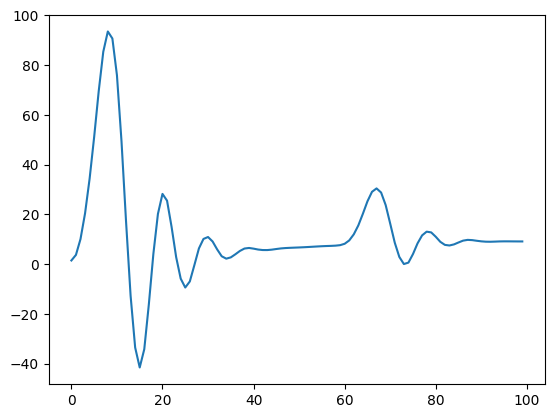

In [31]:
plt.plot(scg)